# Imports

In [1]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da
importlib.reload(dv)
importlib.reload(da)

2024-05-13 18:33:52.056513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 18:33:52.620663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-13 18:33:52.620729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-13 18:33:52.620736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<module 'data_augmentation' from '/home/raaif/Desktop/Uni/y4/FYP/data_augmentation.py'>

# Load Dataset

In [2]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_2s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if k == 'Z_HB_text':
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

# Data augmentation + pair generation

In [3]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    return noised_drifted_signal

def generate_augmented_pairs(batch):
    augmented_batch_1 = np.array([augment_ecg_signal(x) for x in batch])
    augmented_batch_2 = np.array([augment_ecg_signal(x) for x in batch])
    return augmented_batch_1, augmented_batch_2

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# NT-Xent loss (normalized temperature-scaled cross entropy loss)

In [11]:
def contrastive_loss(z1, z2, temperature=0.1):
    # Concatenate positive pairs with all other pairs in the batch
    z = tf.concat([z1, z2], axis=0)
    similarity_matrix = tf.matmul(z, z, transpose_b=True)
    
    # Scale similarity by temperature
    sim = similarity_matrix / temperature
    sim_i_j = tf.linalg.diag_part(sim[:len(z1), len(z1):])
    sim_j_i = tf.linalg.diag_part(sim[len(z1):, :len(z1)])
    
    # Calculate loss
    positives = tf.concat([sim_i_j, sim_j_i], axis=0)
    num_samples = len(positives)
    
    # Subtract the maximum for numerical stability
    logits_max = tf.reduce_max(sim, axis=1, keepdims=True)
    sim -= logits_max
    
    exp_sim = tf.exp(sim)
    sum_exp_sim = tf.reduce_sum(exp_sim, axis=1)
    
    # Negatives: sum of all except positive
    negatives_mask = 1 - tf.eye(num_samples * 2)
    print(exp_sim.shape, negatives_mask.shape)
    negatives = exp_sim * negatives_mask
    sum_negatives = tf.reduce_sum(negatives, axis=1)
    
    loss = -positives + tf.math.log(sum_negatives)
    return tf.reduce_mean(loss)

In [4]:
def nt_xent_loss(x, temperature):
    # cosine similarity
    x_norm = tf.math.l2_normalize(x, axis=1)
    x_cos_sim = tf.matmul(x_norm, x_norm, transpose_b=True)
    
    # mask with -inf on diagonal
    mask = tf.eye(x.shape[0], dtype=tf.bool)
    x_cos_sim = tf.where(mask, -np.inf, x_cos_sim)
    
    # set targets
    samples = x.shape[0]
    target = tf.range(samples)
    target = tf.concat([target[samples//2:], target[:samples//2]], axis=0)
    # target = tf.range(samples)
    # target = tf.where(target % 2 == 0, target + 1, target - 1)
    
    # temperature scaling
    x_cos_sim /= temperature
    
    # loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=x_cos_sim, labels=target)
    loss = tf.reduce_mean(loss)
    
    return loss
    

# Model

In [4]:
def encoder(X):
    
    # conv1
    X = keras.layers.Conv1D(filters=32, kernel_size=3, name='conv1', input_shape=X.shape[1:])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    # conv2
    X = keras.layers.Conv1D(filters=64, kernel_size=3, name='conv2')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    # conv3
    X = keras.layers.Conv1D(filters=128, kernel_size=3, name='conv3')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    # global average pooling
    X = keras.layers.GlobalAveragePooling1D()(X)
    
    # dense
    X = keras.layers.Dense(128, activation='relu', name='dense')(X)
    
    return X

def projection_head(X):
    
    X = keras.layers.Dense(64, activation='relu', name='dense_proj_1')(X)
    X = keras.layers.Dense(32, name='dense_proj_2')(X)

    return X

# Build the full model (encoder + projection head)
def build_simclr_model(input_shape):
    representations = encoder(input_shape)
    projections = projection_head(representations)
    model = keras.Model(inputs=input_shape, outputs=projections)
    return model

In [ ]:
X_input = keras.Input(shape=X_HB.shape[1:])
model = build_simclr_model(X_input)
model.summary()

ecg_dataset = tf.data.Dataset.from_tensor_slices(X_HB)
ecg_dataset = ecg_dataset.shuffle(buffer_size=1024).batch(32)
# ecg_dataset = ecg_dataset.prefetch(tf.data.experimental.AUTOTUNE)

#  SimCLR Training Loop

In [8]:
def train_simclr_model(model, dataset, loss_fn, optimizer, temperature=0.1, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, x_batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                x1, x2 = generate_augmented_pairs(x_batch)
                x = tf.concat([x1, x2], axis=0)
                z = model(x)
                loss = loss_fn(z, temperature)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            if step % 100 == 0:
                print(f"Step {step}, Loss {loss.numpy()}")

In [9]:
train_simclr_model(model, ecg_dataset, nt_xent_loss, keras.optimizers.Adam(), epochs=1)

Epoch 1/1


2024-05-13 17:40:01.449112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 17:40:01.542638: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-13 17:40:01.542676: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-13 17:40:02.207277: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

Step 0, Loss 3.962449550628662
Step 100, Loss 1.1174396276474
Step 200, Loss 0.8800933361053467
Step 300, Loss 0.22989517450332642
Step 400, Loss 0.19943103194236755
Step 500, Loss 0.20426741242408752
Step 600, Loss 0.1447223722934723
Step 700, Loss 0.31552690267562866
Step 800, Loss 0.22627174854278564
Step 900, Loss 0.380207896232605
Step 1000, Loss 0.1466391235589981
Step 1100, Loss 0.2767672836780548
Step 1200, Loss 0.09993095695972443
Step 1300, Loss 0.2700006365776062
Step 1400, Loss 0.21019208431243896
Step 1500, Loss 0.10243050754070282
Step 1600, Loss 0.06391318142414093
Step 1700, Loss 0.0856299102306366
Step 1800, Loss 0.16677843034267426
Step 1900, Loss 0.12502726912498474
Step 2000, Loss 0.230937659740448
Step 2100, Loss 0.18207645416259766
Step 2200, Loss 0.2767230272293091
Step 2300, Loss 0.07506347447633743
Step 2400, Loss 0.1384752243757248
Step 2500, Loss 0.11817996203899384
Step 2600, Loss 0.21008644998073578
Step 2700, Loss 0.20147395133972168
Step 2800, Loss 0.1342

# Save Model

In [10]:
# save keras model
model.save('simclr_model.h5')

# TSNE Visualization of embeddings

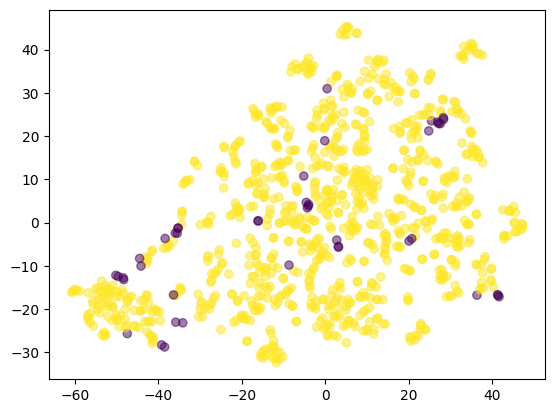

In [49]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.show()


labels_Norm = [0 if "MI" in x else 1 for x in Z_HB_text[:1000]]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]


plot_tsne(model, X_HB[:1000], labels=labels_Norm)
    
    
    

# Finetuning

In [5]:
test_fold = 10
val_fold = 9

X_train = X_HB[np.where(Strat_og_HB <= 8)]
y_train = Z_HB[(Strat_og_HB <= 8)]
y_train_text =Z_HB_text[(Strat_og_HB <= 8)]

X_val = X_HB[np.where(Strat_og_HB == val_fold)]
y_val = Z_HB[Strat_og_HB == val_fold]

X_test = X_HB[np.where(Strat_og_HB == test_fold)]
y_test = Z_HB[Strat_og_HB == test_fold]

print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)

Train data shape:  (204158, 200, 12) Train labels shape:  (204158, 5) Train labels text shape:  (204158,)


In [6]:
num_classes = 5

def build_classifier(X):
    X = keras.layers.Dense(32, activation='relu', name='Dense_class_1')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid', name='Dense_class_2')(X)
    return X

X_input = keras.Input(shape=X_HB.shape[1:])

enc = encoder(X_input)
classifier = build_classifier(enc)

classifier_model = keras.Model(inputs=X_input, outputs=classifier)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
classifier_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
classifier_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 198, 32)           1184      
                                                                 
 batch_normalization (BatchN  (None, 198, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 198, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 196, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 196, 64)          256       
 hNormalization)                                             

2024-05-13 18:35:23.191996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 18:35:23.248714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 18:35:23.248923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 18:35:23.249391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
# load weights from simclr model by name
classifier_model.load_weights('simclr_model.h5', by_name=True)

In [8]:
batch_size = 32

train_generator = augment_ecg_signal_batch(X_train, y_train, batch_size=batch_size)

history = classifier_model.fit(train_generator, epochs=5, batch_size=batch_size, validation_data=(X_val, y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

Epoch 1/5


2024-05-13 18:35:36.613739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 18:35:37.666423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-13 18:35:37.669968: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x303ad5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 18:35:37.669990: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-13 18:35:37.675372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 18:35:37.755343: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

6379/6379 [==============================] - 48s 7ms/step - loss: 0.3159 - accuracy: 0.6879 - precision: 0.7829 - recall: 0.6438 - binary_accuracy: 0.8661 - val_loss: 0.3294 - val_accuracy: 0.6784 - val_precision: 0.7741 - val_recall: 0.6457 - val_binary_accuracy: 0.8635
Epoch 2/5
6379/6379 [==============================] - 45s 7ms/step - loss: 0.2706 - accuracy: 0.7246 - precision: 0.8142 - recall: 0.7133 - binary_accuracy: 0.8874 - val_loss: 0.3117 - val_accuracy: 0.6886 - val_precision: 0.7857 - val_recall: 0.6969 - val_binary_accuracy: 0.8759
Epoch 3/5
6379/6379 [==============================] - 44s 7ms/step - loss: 0.2541 - accuracy: 0.7385 - precision: 0.8261 - recall: 0.7369 - binary_accuracy: 0.8951 - val_loss: 0.3062 - val_accuracy: 0.7150 - val_precision: 0.7927 - val_recall: 0.6930 - val_binary_accuracy: 0.8772
Epoch 4/5
6379/6379 [==============================] - 45s 7ms/step - loss: 0.2445 - accuracy: 0.7417 - precision: 0.8322 - recall: 0.7487 - binary_accuracy: 0.8990